This is a notebook for plotting the development of the prominence of the rhythm of a bee and the share of beeing circadian over different age groups.

# Imports

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib
import datetime
import pytz
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from matplotlib.patches import Patch
from matplotlib import ticker
import numpy as np

import bb_rhythm.plotting
import bb_rhythm.utils

ModuleNotFoundError: No module named 'pandas'

# Functions

In [ ]:
def add_distance_bars(ax, dist, distance_series, alpha_series):
    distances = pd.qcut(dist[distance_series].unique(), len(dist[distance_series].unique()))
    alpha = dist.groupby([distance_series])[alpha_series].mean().reset_index().sort_values(by=distance_series)[alpha_series].round(2)
    alpha = (alpha - alpha.min()) / (alpha.max() - alpha.min())
    i = 0
    for distance in sorted(distances.unique()):
        if i == 0:
            print(alpha[i])
            ax.axvspan(
                distance.left - 5, distance.right, color="white", edgecolor=None, facecolor=None, linewidth=0, alpha=alpha[i], zorder=2
            )
        elif i == (len(distances.unique()) -1):
            ax.axvspan(
                distance.left, distance.right + 10, color="white", edgecolor=None, facecolor=None, linewidth=0, alpha=alpha[i], zorder=2
            )
        else:
            ax.axvspan(
                distance.left, distance.right, color="white", edgecolor=None, facecolor=None, linewidth=0, alpha=alpha[i], zorder=2
            )
        i += 1

## 2019

## Prepare and read data

# a)

In [3]:
# cosinor fit data for period 2019
df_2019 = pd.read_pickle("../../diurnal_rhythm_paper/data/dataframes/circadianess_2019/cosinor_3600.pkl")

# define bees being circadian with results of zero amplitude test being < 0.05
df_2019["is_circadian"] = df_2019.p_value < 0.05

In [4]:
# movement speeds
velocity_df_2019 = pd.read_pickle("../diurnal_rhythm_paper/data/dataframes/velocity_weather_over_time_2019/velocity_mean_10min_all_bb2019_bayesian_bees.pkl")
velocities_young = pd.read_pickle("../../plots/5101.pkl")
velocities_old = pd.read_pickle("../../plots/2088.pkl")

In [5]:
# define age groups of bees and create bins accordingly
binning = bb_rhythm.utils.Binning(bin_name="Age [days]", bin_parameter="age")
df_2019_plt = binning.add_bins_to_df(df_2019.dropna(), bins=[0, 4, 9, 14, 19, 24, 29, 34], step_size=None)
# add age bins
binning = bb_rhythm.utils.Binning(bin_name="Age [days]", bin_parameter="age")
velocity_df_2019 = binning.add_bins_to_df(velocity_df_2019, bins=[0, 4, 9, 14, 19, 24, 29, 34])

# create color palette
palette = bb_rhythm.plotting.create_age_color_palette(
        sorted(df_2019_plt["Age [days]"].unique()), "Age [days]", df_2019_plt
    )
day = datetime.datetime(2019, 9, 12, 12, tzinfo=pytz.utc)

# set time and subset
dt_from = pd.to_datetime(datetime.datetime(2019, 9, 11), utc=True)
dt_to = pd.to_datetime(datetime.datetime(2019, 9, 14), utc=True)
velocity_df_2019_subperiod = velocity_df_2019[((velocity_df_2019["date"] >= dt_from)
        & (velocity_df_2019["date"] < dt_to))]

# get velocity young data
velocities_young["datetime"] = velocities_young["datetime"].dt.round("%ss" % 3600)
velocities_young_median = velocities_young.groupby(["datetime"])[["velocity", "time_passed"]].median().reset_index()
A_young = df_2019[(df_2019.bee_id == 5101) & (df_2019.date == day)].amplitude.values[0]
P_young = df_2019[(df_2019.bee_id == 5101) & (df_2019.date == day)].phase.values[0]
M_young = df_2019[(df_2019.bee_id == 5101) & (df_2019.date == day)].mesor.values[0]
x_young = np.array([t.total_seconds() for t in velocities_young.datetime - day])
y_young = A_young*np.cos(x_young-P_young) + M_young

# get velocity old data
velocities_old["datetime"] = velocities_old["datetime"].dt.round("%ss" % 3600)
velocities_old_median = velocities_old.groupby(["datetime"])[["velocity", "time_passed"]].median().reset_index()
A_old = df_2019[(df_2019.bee_id == 2088) & (df_2019.date == day)].amplitude.values[0]
P_old = df_2019[(df_2019.bee_id == 2088) & (df_2019.date == day)].phase.values[0]
M_old = df_2019[(df_2019.bee_id == 2088) & (df_2019.date == day)].mesor.values[0]
x_old = np.array([t.total_seconds() for t in velocities_old.datetime - day])
y_old = A_old*np.cos(x_old-P_old) + M_old

/home/julia/arbeit/hiveopolis/bb_rhythm/bb_rhythm/utils.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[self.bin_name] = [self.bin_labels[item] for item in self.bins]
/home/julia/arbeit/hiveopolis/bb_rhythm/bb_rhythm/utils.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(subset=[self.bin_name], inplace=True)


In [27]:
# bar plot frame
df_bar = df_2019_plt.groupby(["Age [days]"]).agg(
     no=("is_circadian", lambda x: 100),
     yes=("is_circadian", lambda x: x.sum() / x.count() * 100),
).rename(columns={"yes": "Circadian", "no": "Non-circadian"}).reset_index()

/home/julia/arbeit/hiveopolis/bb_rhythm/bb_rhythm/plotting.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_age_velocity_df["velocity_smoothed"] = time_age_velocity_df["velocity"]
/home/julia/arbeit/hiveopolis/bb_rhythm/bb_rhythm/plotting.py:243: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_age_velocity_df["velocity_smoothed"][
/home/julia/arbeit/hiveopolis/bb_rhythm/bb_rhythm/plotting.py:243: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/

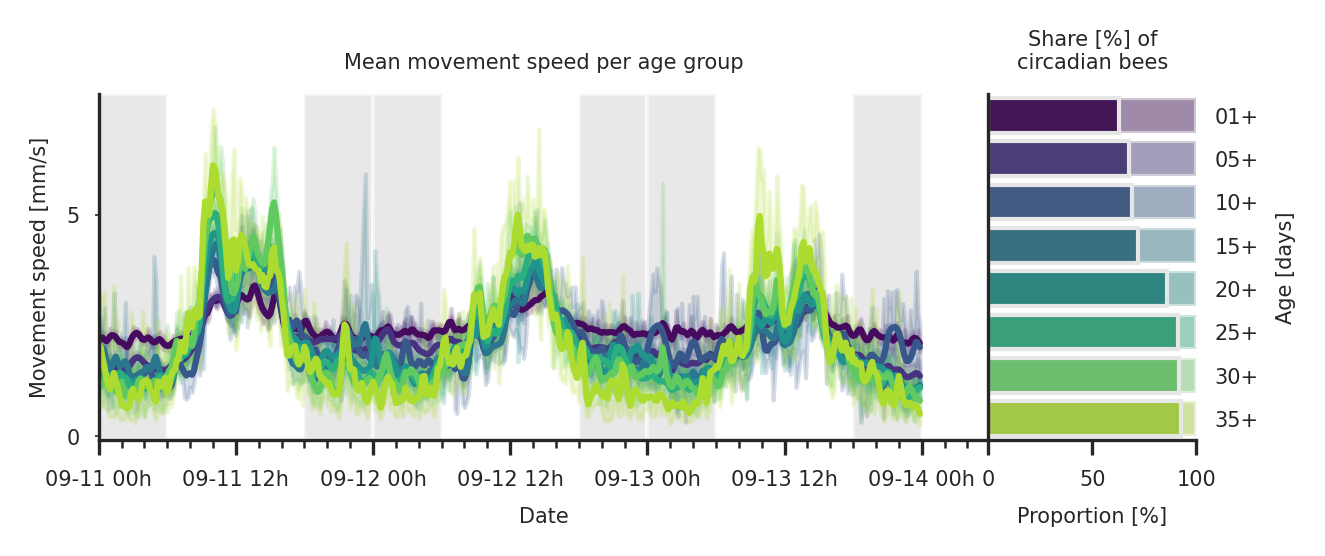

In [62]:
sns.set_style("ticks")
matplotlib.rcParams.update({'font.size': 5, 'ytick.major.size': 1,
                                'ytick.major.width': 0.4, 'font.sans-serif': 'Arial'})

# A
fig, ax = plt.subplots(1, 2, figsize=(4.2, 1.35), gridspec_kw={'width_ratios': [7.5, 1.75], 'wspace': 0.00}, dpi=300)

bb_rhythm.plotting.add_grey_nighttime_bars(ax[0], velocity_df_2019_subperiod)
bb_rhythm.plotting.plot_smoothed_age_velocity_over_time(ax[0], palette, "Age [days]", velocity_df_2019_subperiod, hue_order=sorted(df_2019_plt["Age [days]"].unique()))
ax[0].set_xlim(velocity_df_2019_subperiod.date.min(), velocity_df_2019_subperiod.date.max() + datetime.timedelta(hours=6))

# barplot
sns.barplot(data=df_bar, y="Age [days]", x="Non-circadian", ax=ax[1], palette=palette, order=sorted(df_2019_plt["Age [days]"].unique()), alpha=0.5)
sns.barplot(data=df_bar, y="Age [days]", x="Circadian", ax=ax[1], palette=palette, order=sorted(df_2019_plt["Age [days]"].unique()), edgecolor=".9")
ax[1].set_xlabel("Proportion [%]")
ax[1].set_xlim(0, 100.0)
ax[1].set_title("Share [%] of\nrhythmic bees", fontsize=rcParams['axes.labelsize'])
sns.despine(ax=ax[1])
ax[1].yaxis.set_label_position("right")
ax[1].yaxis.tick_right()
ax[1].tick_params(right=False)
ax[1].grid(False)
ax[1].tick_params(bottom=True)

date_form = matplotlib.dates.DateFormatter("%m-%d %Hh")
ax[0].xaxis.set_major_formatter(date_form)
ax[0].legend().remove()
ax[0].set_ylabel('Movement speed [mm/s]')
ax[0].set_xlabel("Date")
ax[0].set_title("Mean movement speed per age group", fontsize=rcParams['axes.labelsize'])
ax[0].xaxis.set_minor_locator(mdates.HourLocator(byhour=[2, 4, 6, 8, 10, 14, 16, 18, 20, 22]))
ax[0].tick_params(which='minor', length=2)
ax[0].yaxis.set_major_locator(ticker.MultipleLocator(5))
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=15, ha='right')
ax[0].grid(False)
sns.despine()
plt.savefig("plot_1_a.svg")

### b)

/home/julia/.local/share/virtualenvs/diurnal_rhythm_paper-zh8zkZvR/lib/python3.8/site-packages/seaborn/relational.py:573: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  points = ax.scatter(x=x, y=y, **kws)
/tmp/ipykernel_8183/2953512812.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic fami

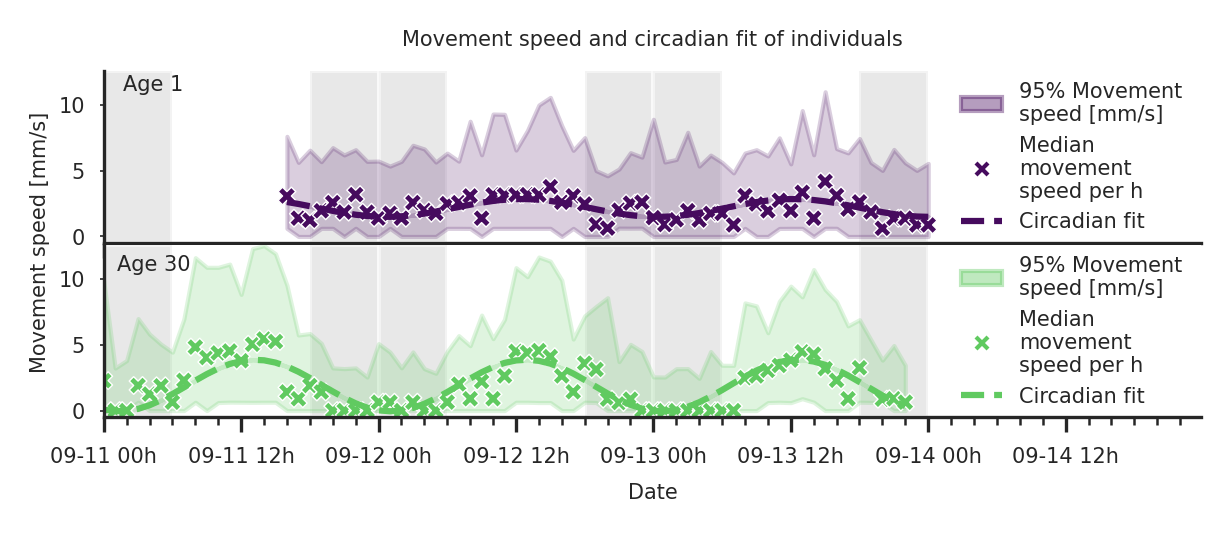

In [63]:
sns.set_style("ticks")
matplotlib.rcParams.update({'font.size': 5, 'ytick.major.size': 1,
                                'ytick.major.width': 0.4, 'font.sans-serif': 'Arial'})

# A
fig, ax = plt.subplots(2, 1, figsize=(3.243, 1.35), gridspec_kw={'height_ratios': [0.5, 0.5], 'hspace': 0.01}, sharex=True, dpi=300)

# add grey nighttimes
bb_rhythm.plotting.add_grey_nighttime_bars(ax[0], velocity_df_2019_subperiod)
# plot cosinor fit
sns.lineplot(x=velocities_young.datetime.values, y=y_young, c=palette[0], label="Cosinor model", ax=ax[0], linestyle="--")
# plot 95% percentile velocities
sns.lineplot(
      data=velocities_young, x="datetime", y="velocity",
      errorbar=("pi", 90),
      color=palette[0], ax=ax[0], label="Movement speed", estimator="median", linewidth=0,
)
# plot median velocities
sns.scatterplot(velocities_young_median, x="datetime", y="velocity", c=palette[0], marker="X", size=0.75, ax=ax[0], label="Median movement\nspeed per h")

# add grey nightimes
bb_rhythm.plotting.add_grey_nighttime_bars(ax[1], velocity_df_2019_subperiod)
# plot cosinor fit
sns.lineplot(x=velocities_old.datetime.values, y=y_old, color=palette[6], label="Cosinor model", ax=ax[1], linestyle="--")
# plot 95% percentile velocities
sns.lineplot(     
     data=velocities_old, x="datetime", y="velocity",
      errorbar=("pi", 90),
      color=palette[6], ax=ax[1], label="Movement speed", estimator="median", linewidth=0,
 )
# plot median velocities
sns.scatterplot(velocities_old_median, x="datetime", y="velocity", color=palette[6], marker="X", size=0.75, ax=ax[1], label="Median movement\nspeed per h")

date_form = matplotlib.dates.DateFormatter("%m-%d %Hh")
ax[1].xaxis.set_major_formatter(date_form)
ax[0].set_ylim(-0.5, 12.6)
ax[1].set_ylim(-0.5, 12.6)
ax[0].set_xlim(velocity_df_2019_subperiod.date.min(), velocity_df_2019_subperiod.date.max() + datetime.timedelta(hours=6))
ax[1].set_xlim(velocity_df_2019_subperiod.date.min(), velocity_df_2019_subperiod.date.max() + datetime.timedelta(hours=6))
ax[1].set_ylabel("")
ax[0].set_ylabel("")
ax[1].set_xlabel("Date")
ax[0].set_title("Movement speed and cosinor fit of individuals", fontsize=rcParams['axes.labelsize'])
ax[1].xaxis.set_minor_locator(mdates.HourLocator(byhour=[2, 4, 6, 8, 10, 14, 16, 18, 20, 22]))
ax[1].tick_params(which='minor', length=2)
ax[0].yaxis.set_major_locator(ticker.MultipleLocator(5))
ax[1].yaxis.set_major_locator(ticker.MultipleLocator(5))
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=15, ha='right')

legends = [
    (mpatches.Patch(color='black', alpha=0.4), '95% Movement\nspeed [mm/s]'), 
    ((mlines.Line2D([], [], color='black', marker='x', linewidth=0, markersize=3)), "Median\nmovement speed per h"), 
    ((mlines.Line2D([], [], color='black', linestyle='--')), 'Cosinor fit'),
    (mpatches.Patch(color=palette[0], alpha=0.4), 'Invidual bee\nID: 5101, Age: 1 [d]'),
    (mpatches.Patch(color=palette[6], alpha=0.4), 'Invidual bee\nID: 2088, Age: 30 [d]'),
]
leg = ax[0].legend(*zip(*legends), loc='upper left', frameon=False)
ax[1].get_legend().remove()
fig.text(0.16, 0.85, 'Day 0 ', va='center', ha='center', fontsize=rcParams['axes.labelsize'])
fig.text(0.4, 0.85, 'Day 1 ', va='center', ha='center', fontsize=rcParams['axes.labelsize'])
fig.text(0.625, 0.85, 'Day 2 ', va='center', ha='center', fontsize=rcParams['axes.labelsize'])
fig.text(0.16, 0.45, 'Day 29', va='center', ha='center', fontsize=rcParams['axes.labelsize'])
fig.text(0.4, 0.45, 'Day 30', va='center', ha='center', fontsize=rcParams['axes.labelsize'])
fig.text(0.625, 0.45, 'Day 31', va='center', ha='center', fontsize=rcParams['axes.labelsize'])
fig.text(0.06, 0.5, 'Movement speed [mm/s]', va='center', ha='center', fontsize=rcParams['axes.labelsize'], rotation='vertical')
sns.despine()
plt.tight_layout()
plt.savefig("plot_1_b.svg")

In [64]:
dist = pd.read_pickle("../../plots/pivot_dist_plot.pkl")
dist.columns = dist.columns.map(lambda x: x[0] + "_" + x[1] if len(x[1]) > 0 else x[0])

In [65]:
dist = dist[dist["phase_focal_count"] > dist["phase_focal_count"].quantile(0.05)]
dist["entrance_dist_focal_median_round"] = dist["entrance_dist_focal_median"].round(-1)
dist = dist.groupby(["entrance_dist_focal_median_round"]).median().reset_index()
dist["phase_focal_q"] = 1 - (dist["phase_focal_median"] - dist["phase_focal_median"].min())/(dist["phase_focal_median"].max() - dist["phase_focal_median"].min())
dist["phase_focal_std_q"] = 1 - (dist["phase_focal_std"] - dist["phase_focal_std"].min())/(dist["phase_focal_std"].max() - dist["phase_focal_std"].min())
dist["age_focal_q"] = (dist["age_focal_median"] - dist["age_focal_median"].min())/(dist["age_focal_median"].max() - dist["age_focal_median"].min())
dist["r_squared_focal_q"] = (dist["r_squared_focal_median"] - dist["r_squared_focal_median"].min())/(dist["r_squared_focal_median"].max() - dist["r_squared_focal_median"].min())
dist["phase_focal_count_q"] = 1 - (dist["phase_focal_count"] - dist["phase_focal_count"].min())/(dist["phase_focal_count"].max() - dist["phase_focal_count"].min())

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

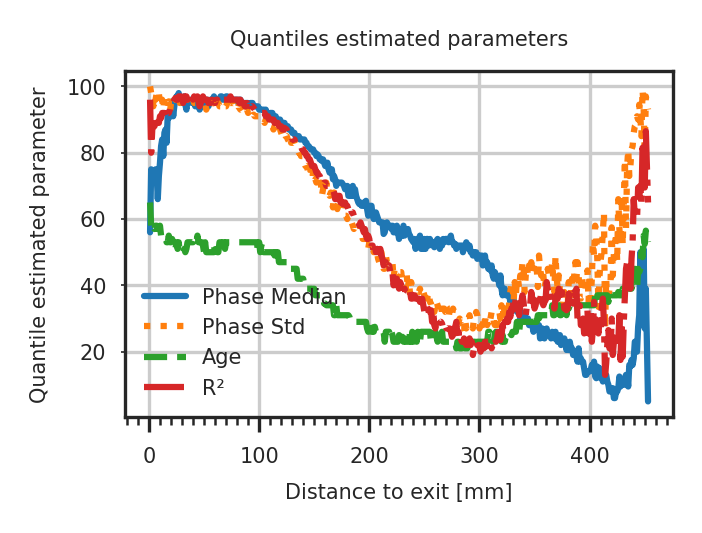

In [69]:
sns.set_style("ticks")
sns.set_palette(sns.color_palette("colorblind"))
matplotlib.rcParams.update({'font.size': 5, 'ytick.major.size': 1,
                                'ytick.major.width': 0.4, 'font.sans-serif': 'Arial'})

# A
fig, ax = plt.subplots(1, 5, figsize=(4.2, 1.35), gridspec_kw={"width_ratios":[1.0, 0.0, 0.0, 0.0, 0.0], "wspace": 0.5}, dpi=300)
sns.lineplot(dist, x="entrance_dist_focal_median_round", y="phase_focal_q", ax=ax[0], estimator="median", errorbar=None,
             label="Phase Median", markers=True)#linestyle="solid", markers=True)#, dashes=False)
sns.lineplot(dist, x="entrance_dist_focal_median_round", y="phase_focal_std_q", ax=ax[0], estimator="median",
             errorbar=None,
             label="Phase Std", linestyle="dotted", markers=True, dashes=False)
sns.lineplot(dist, x="entrance_dist_focal_median_round", y="age_focal_q", ax=ax[0], estimator="median", errorbar=None,
             label="Age Median", linestyle="dashed", markers=True, dashes=False)
sns.lineplot(dist, x="entrance_dist_focal_median_round", y="r_squared_focal_q", ax=ax[0], estimator="median",
             errorbar=None, label="R² Median", linestyle="dashdot", markers=True, dashes=False)
ax[0].xaxis.set_major_locator(ticker.MultipleLocator(50))
ax[0].set_xlim(0, dist["entrance_dist_focal_median_round"].max())
ax[0].set_ylim(0, 1)
add_distance_bars(ax[0], dist, "entrance_dist_focal_median_round", "phase_focal_count_q")
sns.despine(ax=ax[0])
ax[0].tick_params(axis='y', which='major', pad=1)
ax[0].legend(frameon=False, loc='upper right')#bbox_to_anchor=(1.008, 1.), loc='upper left', borderaxespad=0., title="Estimated Parameters")
ax[0].set_xlabel("Distance to exit [mm]")
ax[0].set_ylabel("Phase Median/ Phase Std/ Age Median/\nR² Median (Min-Max Normalized)")#Quantile estimated parameter")
ax[0].xaxis.set_major_locator(ticker.MultipleLocator(50))
ax[0].tick_params(which='minor', length=2)
ax[1].get_xaxis().set_visible(False)
sns.despine(ax=ax[1])
ax[1].set_yticklabels([np.round(i/10*dist["phase_focal_median"].min() + dist["phase_focal_median"].max()*(-i/10) + dist["phase_focal_median"].max(), 1) for i in range(0, 12, 2)])
ax[2].get_xaxis().set_visible(False)
sns.despine(ax=ax[1])
ax[2].set_yticklabels([np.round(i/10*dist["phase_focal_std"].min() + dist["phase_focal_std"].max()*(-i/10) + dist["phase_focal_std"].max(), 1) for i in range(0, 12, 2)])
ax[3].get_xaxis().set_visible(False)
sns.despine(ax=ax[3])
ax[3].set_yticklabels([np.round(-(i/10-1)*dist["age_focal_median"].min() + dist["age_focal_median"].max()*(i/10), 1) for i in range(0, 12, 2)])
ax[4].get_xaxis().set_visible(False)
sns.despine(ax=ax[4])
ax[4].set_yticklabels([np.round(-(i/10-1)*dist["r_squared_focal_median"].min() + dist["r_squared_focal_median"].max()*(i/10), 2) for i in range(0, 12, 2)])
ax[4].tick_params(axis='y', which='major', pad=1)
ax[1].tick_params(axis='y', which='major', pad=1)
ax[2].tick_params(axis='y', which='major', pad=1)
ax[3].tick_params(axis='y', which='major', pad=1)
ax[4].tick_params(axis='y', which='major', pad=1)
ax[1].set_title("P", fontsize=rcParams['axes.labelsize'])
ax[1].yaxis.set_label_position("right")
ax[2].set_title("PStd", fontsize=rcParams['axes.labelsize'])
ax[2].yaxis.set_label_position("right")
ax[3].set_title("Age", fontsize=rcParams['axes.labelsize'])
ax[3].yaxis.set_label_position("right")
ax[4].set_title("R²", fontsize=rcParams['axes.labelsize'])
ax[4].yaxis.set_label_position("right")
ax[0].set_title("Rhythm Parameters at distances to exit", fontsize=rcParams['axes.labelsize'])
plt.tight_layout()
plt.savefig("plot_1_d.svg")

### d)

In [ ]:
import cv2
from scipy.ndimage.filters import gaussian_filter
import scipy
dist = pd.read_pickle("../../plots/pivot_dist_plot.pkl")
dist.columns = dist.columns.map(lambda x: x[0] + "_" + x[1] if len(x[1]) > 0 else x[0])
dist["x_pos_start_focal"] = dist["x_pos_start_focal"].round()
dist["y_pos_start_focal"] = dist["y_pos_start_focal"].round()
frame = cv2.imread('../../plots/frame.png')
entrance_coordinates = (5, 264)

In [ ]:
dist[dist["phase_focal_count"] > dist["phase_focal_count"].quantile(0.05)]["age_focal_median"] = np.NaN

In [ ]:
sns.set_style("ticks")
sns.set_palette(sns.color_palette("colorblind"))
matplotlib.rcParams.update({'font.size': 5, 'ytick.major.size': 1, 'ytick.major.width': 0.4, 'font.sans-serif': 'Arial'})

fig, ax = plt.subplots(1, 1, figsize=(3.24, 1.35), dpi=300)
ax.imshow(scipy.ndimage.zoom(frame[:, :, 0], 0.1), cmap='gray', vmin=0, vmax=255)
ax.text(10, 270, 'Exit', va='top', ha='left', fontsize=rcParams['axes.labelsize'])
ax.arrow(x=5+15, y=264-15, dx=-15, dy=15, color='red', zorder=10, width=5)
sns.despine(ax=ax)
ax.set_xlabel("X-position [mm]")
ax.set_ylabel("Y-position [mm]")
x="y_pos_start_focal" 
y="x_pos_start_focal"
dist_90 = dist.copy()
pivot_90 = dist_90.pivot_table(index=x, columns=y, values="age_focal_median", aggfunc=np.nanmedian, dropna=False)
X, Y = np.meshgrid(sorted(dist.x_pos_start_focal.unique()), sorted(dist.y_pos_start_focal.unique()))
Z = pivot_90
Z = gaussian_filter(Z, 3)
cp = ax.contourf(X, Y, Z, cmap='viridis', levels=[0, 5, 10, 15, 20, 25, 30, 35, 40], alpha=0.4)
cp = ax.contour(X, Y, Z, cmap='viridis', levels=[0, 5, 10, 15, 20, 25, 30, 35, 40], alpha=1.0, linewidth=0.8)
ax.xaxis.set_major_locator(ticker.MultipleLocator(50))
ax.set_title("Median Age [d]", fontsize=rcParams['axes.labelsize'])
plt.savefig("plot_1_c.svg")